In [1]:
import torch
from torch import nn
from torchvision.datasets import MovingMNIST
import torchvision

In [2]:
if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
device

'cuda'

# Nochmal ein VAE

In [3]:
dataset_train = MovingMNIST(root='./data', split="train", download=True)

100%|██████████| 819M/819M [01:28<00:00, 9.31MB/s]


In [ ]:
video = dataset_train[23]
print(video.shape)
video_frame = video[8]
print(video_frame.shape)

torch.Size([10, 1, 64, 64])
torch.Size([1, 64, 64])


In [58]:
#sammle frames
frames = []
for i in range(len(dataset_train[:500])):
  video = dataset_train[i]

  for j in range(video.shape[0]):
    video_frame = video[j]
    frames.append(video_frame)
len(frames)

5000

In [59]:
from torch.utils.data.dataloader import DataLoader
#baue dataset und loader
from torch.utils.data import Dataset
from torchvision import transforms

transforms = transforms.ToTensor()

class VAEDataset(Dataset):
  def __init__(self, frames, transform):
    self.frames = frames
    self.transform = transform

  def __len__(self):
    return len(self.frames)

  def __getitem__(self, idx):
    transformed_tensor = self.transform(self.frames[idx].numpy())

    return transformed_tensor.permute(1, 0, 2)

vaedataset = VAEDataset(frames, transforms)


#Dataloader
vae_loader = DataLoader(vaedataset, batch_size=8, shuffle=True)
vae_loader

torch.Size([1, 64, 64])
torch.Size([64, 64])


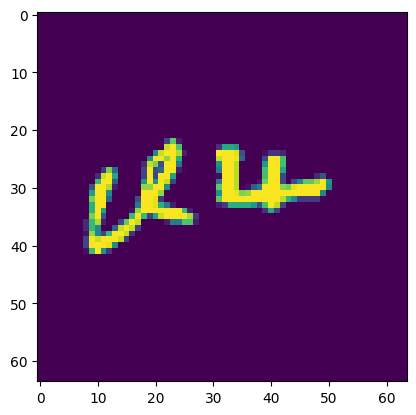

In [63]:
img = next(iter(vaedataset))
print(img.shape)
from matplotlib import pyplot as plt
img = img.squeeze()
print(img.shape)
plt.imshow(img.numpy(), interpolation='nearest')
plt.show()

In [60]:
class VAE(nn.Module):
  def __init__(self, input_shape, latent):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(input_shape, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),

        nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),

        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),

        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),
        nn.Flatten()
    )

    self.latent_dim = latent
    self.fc_mu = nn.Linear(256 * 4 * 4, self.latent_dim)
    self.fc_logvar = nn.Linear(256 * 4 * 4, self.latent_dim)
    self.decoder_input = nn.Linear(self.latent_dim, 256*4*4)

    self.decoder = nn.Sequential(
        nn.Unflatten(1, (256, 4, 4)),

        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),

        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),

        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
        nn.ReLU(),

        nn.ConvTranspose2d(32, input_shape, kernel_size=4, stride=2, padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    mu, logvar = self.encode(x)
    h = self.reparameterize(mu, logvar)
    return self.decode(h), mu, logvar

  def encode(self, x):
    h = self.encoder(x)
    return self.fc_mu(h), self.fc_logvar(h)

  def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

  def decode(self, x):
    h = self.decoder_input(x)
    return self.decoder(h)

  def loss(self, recon, x, mu, logvar, beta=2.0):
    batch_size = x.size(0)
    recon_loss = nn.functional.mse_loss(recon, x, reduction='sum') / batch_size

    kl_loss = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())) / batch_size


    total_loss = recon_loss + beta * kl_loss

    return total_loss, recon_loss, kl_loss

In [7]:
model = VAE(1, 32).to(device)
input_dummy = torch.randn(1, 1, 64, 64).to(device)
#_, _2 = model.encode(img)

In [61]:
model.load_state_dict(torch.load("/content/modelVAE.pth", weights_only=True))

<All keys matched successfully>

In [9]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

In [ ]:
#train vae
model.train()

epochs = 40

for epoch in range(epochs):
  train_loss = 0
  for img in vae_loader:
    img = img.to(device)

    recon, mu, logvar = model(img.squeeze(0))
    loss, recon_loss, kl = model.loss(recon, img.squeeze(0), mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  avg_epoch_loss = train_loss / len(vae_loader)
  print(f"Epoch: {epoch}, Loss: {avg_epoch_loss:.4f}")


Epoch: 0, Loss: 121.6434
Epoch: 1, Loss: 121.5126
Epoch: 2, Loss: 121.1724
Epoch: 3, Loss: 120.7446
Epoch: 4, Loss: 120.5492
Epoch: 5, Loss: 120.0828
Epoch: 6, Loss: 119.8972
Epoch: 7, Loss: 119.5012
Epoch: 8, Loss: 119.1925
Epoch: 9, Loss: 119.1269
Epoch: 10, Loss: 118.6020
Epoch: 11, Loss: 118.3083
Epoch: 12, Loss: 118.0676
Epoch: 13, Loss: 117.8786
Epoch: 14, Loss: 117.7373
Epoch: 15, Loss: 117.4907
Epoch: 16, Loss: 117.3558
Epoch: 17, Loss: 116.6831
Epoch: 18, Loss: 116.7465
Epoch: 19, Loss: 116.2269
Epoch: 20, Loss: 116.3108
Epoch: 21, Loss: 115.9447
Epoch: 22, Loss: 115.8611
Epoch: 23, Loss: 115.5991
Epoch: 24, Loss: 115.2112
Epoch: 25, Loss: 115.0971
Epoch: 26, Loss: 114.9436
Epoch: 27, Loss: 114.8880
Epoch: 28, Loss: 114.5571
Epoch: 29, Loss: 114.0438
Epoch: 30, Loss: 114.0508
Epoch: 31, Loss: 113.8202
Epoch: 32, Loss: 113.5145
Epoch: 33, Loss: 113.4702
Epoch: 34, Loss: 113.1436
Epoch: 35, Loss: 112.9587
Epoch: 36, Loss: 112.7594
Epoch: 37, Loss: 112.4769
Epoch: 38, Loss: 112.3

torch.Size([64, 64])


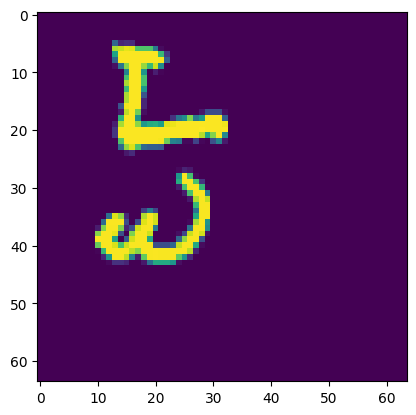

torch.Size([64, 64])


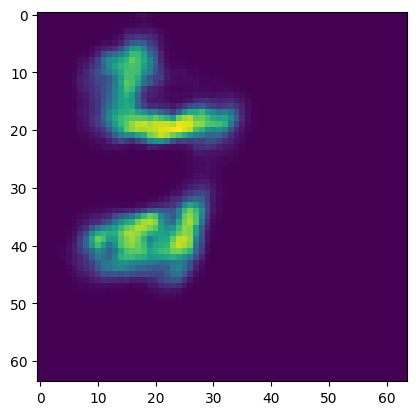

In [64]:
img= next(iter(vae_loader))
img = img.to(device)

with torch.no_grad():
  reconstructed, mu, logvar = model(img.squeeze(0))

  img = img[0]
  img = img.squeeze()
  print(img.shape)
  plt.imshow(img.cpu().numpy(), interpolation='nearest')
  plt.show()

  reconstructed = reconstructed[0]
  reconstructed = reconstructed.squeeze()
  print(reconstructed.shape)
  plt.imshow(reconstructed.cpu().numpy(), interpolation='nearest')
  plt.show()

In [ ]:
torch.save( model.state_dict(),"modelVAE.pth")

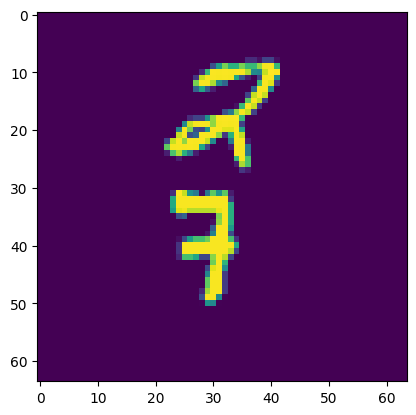

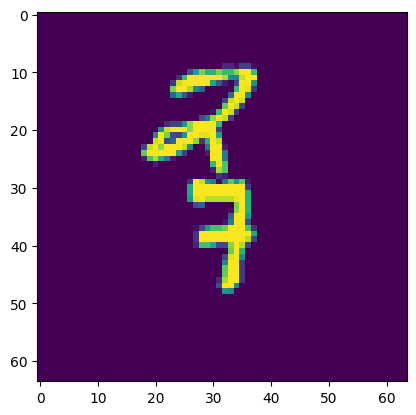

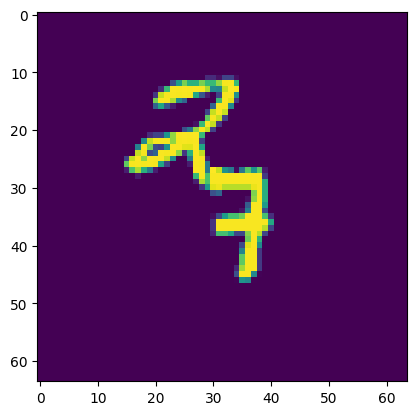

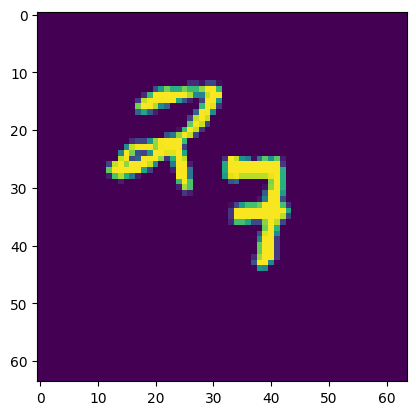

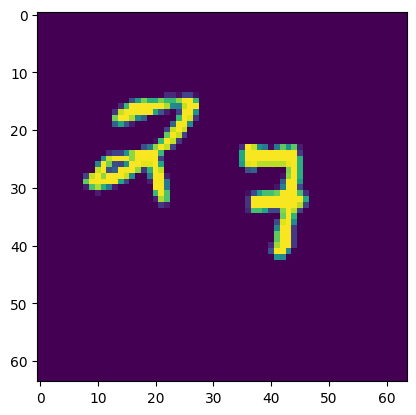

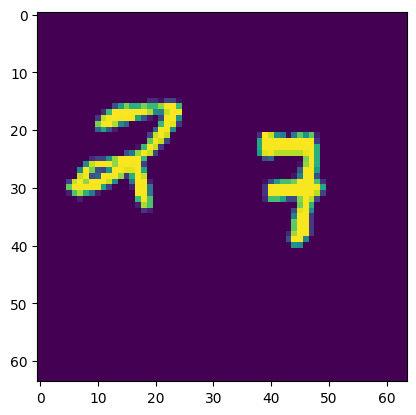

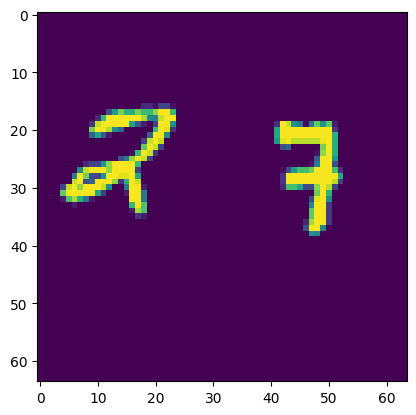

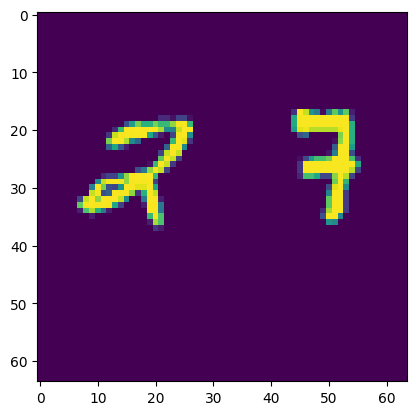

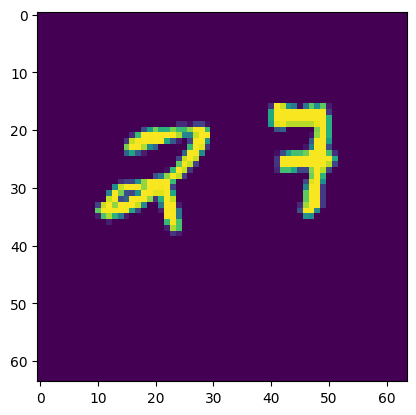

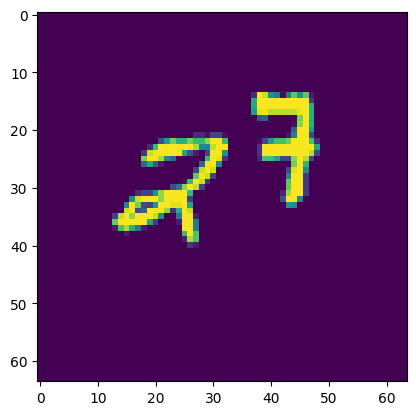

In [ ]:
from matplotlib import pyplot as plt

for i in range(10):
  video_frame = video[i]
  img = video_frame.squeeze()
  plt.imshow(img.numpy(), interpolation='nearest')
  plt.show()

# MDNRNN

In [11]:
#mdn rnn components
class RNN(nn.Module):
  def __init__(self, latent_dim, hidden_size, num_layers=1):
    super().__init__()

    self.lstm = nn.LSTM(latent_dim, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.hidden_size = hidden_size

  #für das world model 2018 muss man zu x bzw z noch a hinzufügen für die actions
  def forward(self, x, h=None):
    out_rnn, h = self.lstm(x, h)
    return out_rnn, h

In [158]:
import torch.nn.functional as F

class MDN(nn.Module):
  def __init__(self, latent_dim, hidden_dim, num_gaussians):
    super().__init__()
    self.num_gaussians = num_gaussians
    self.latent_dim = latent_dim

    self.fc_pi = nn.Linear(hidden_dim, num_gaussians) # Corrected output dimension
    self.fc_mu = nn.Linear(hidden_dim, latent_dim * num_gaussians)
    self.fc_sigma = nn.Linear(hidden_dim, num_gaussians * latent_dim)

  def forward(self, outs_rnn, tau):
    pi = self.fc_pi(outs_rnn)
    mu = self.fc_mu(outs_rnn)
    sigma = self.fc_sigma(outs_rnn)


    #jede warscheinlichkeitsverteilung in der sequenz hat so galube ich einen eigenen latent vecktor
    batch_size, seq_length, _ = outs_rnn.size()
    mu = mu.view(batch_size, seq_length, self.num_gaussians, self.latent_dim)
    sigma = sigma.view(batch_size, seq_length, self.num_gaussians, self.latent_dim)

    sigma = torch.exp(sigma) + 1e-15
    sigma = sigma * torch.sqrt(torch.tensor(tau))  # Scale sigma mit temperature

    pi = F.softmax(pi/tau, dim=-1) + 1e-15

    return pi, mu, sigma

In [159]:
class MDNRNN(nn.Module):
  def __init__(self, latent_dim, hidden_dim,num_gaussians, num_layers=1 ):
    super().__init__()
    self.rnn = RNN(latent_dim, hidden_dim, num_layers)
    self.mdn = MDN(latent_dim, hidden_dim, num_gaussians)

  def forward(self,z, tau=1.0,h=None):
    outs_rnn, h = self.rnn(z, h)
    pi, mu, sigma = self.mdn(outs_rnn, tau)
    return pi, mu, sigma, h

In [160]:
def sample_mdn(pi, mu, sigma):
  # Select a Gaussian component based on mixture weights (glaub ich in der funktion multinominal)
  component_index = torch.multinomial(pi.view(-1), 1).item()

  selected_mu = mu[0, 0, component_index]
  selected_sigma = sigma[0, 0, component_index]

  epsilon = torch.randn(selected_mu.size(), device=mu.device)
  z = selected_mu + selected_sigma * epsilon
  return z.unsqueeze(0).unsqueeze(0)

In [169]:
from torch.distributions import Normal
def gaussian_nll_loss(pi, mu, sigma, z_next):
    """
    Compute the negative log-likelihood loss for a mixture of Gaussians.

    Args:
        pi: Mixture weights [batch, seq, num_gaussians]
        mu: Gaussian means [batch, seq, num_gaussians, latent_dim]
        sigma: Gaussian std devs [batch, seq, num_gaussians, latent_dim]
        z_next: Target latent vectors [batch, seq, latent_dim]

    Returns:
        nll: Scalar negative log-likelihood loss
    """
    z_next = z_next.unsqueeze(2)  # Add dim for num_gaussians: [batch, seq, 1, latent_dim]
    log_pi = torch.log(pi)

    # Create normal distributions for each mixture component
    normal_dist = Normal(loc=mu, scale=sigma)  # [batch, seq, num_gaussians, latent_dim]

    # Compute log probabilities for the target z_next
    log_prob = normal_dist.log_prob(z_next)  # [batch, seq, num_gaussians, latent_dim]

    # Sum log probabilities across the latent dimension
    log_prob = log_prob.sum(-1)  # [batch, seq, num_gaussians]

    # Use log-sum-exp trick for numerical stability
    log_sum_exp = torch.logsumexp(log_pi + log_prob, dim=-1)  # [batch, seq]

    # Mean negative log-likelihood
    nll = -log_sum_exp.mean()
    return nll

In [170]:
#dataset für das mdn rnn vorberieten
#versuche die frames zu spliten für frame und frame_next (VAE nutzen und in dataloader packen)

#dataset_train[:500]

_frames = []

for i in range(500):
  video = dataset_train[i]
  #print(video.shape)

  for j in range(video.shape[0] -1):
    frame = video[j]
    frame_next = video[j+1]

    _frames.append(frame)
    _frames.append(frame_next)


print(len(_frames))
f = _frames[0]
f_next = _frames[1]
print(f.shape)
print(f_next.shape)

9000
torch.Size([1, 64, 64])
torch.Size([1, 64, 64])


In [171]:
from torch.utils.data import Dataset, DataLoader

class VideoDataset(Dataset):
  def __init__(self, _frames, transform=None, vaeModel=None):
    self._frames = _frames
    self.transform = transform
    self.vaeModel = vaeModel

  def __len__(self):
    return len(self._frames)-1

  def __getitem__(self, idx):
    if self.transform != None:
      f = self.transform(self._frames[idx])
      f_next = self.transform(self._frames[idx+1])
    else:
      f = self._frames[idx]/255
      f_next = self._frames[idx+1]/255

    #apply the vae
    with torch.no_grad():
      #print(f.shape)
      #print(f_next.shape)

      mu, logvar = self.vaeModel.encode(f.unsqueeze(0).to(device))
      z = self.vaeModel.reparameterize(mu, logvar)

      mu, logvar = self.vaeModel.encode(f_next.unsqueeze(0).to(device))
      z_next = self.vaeModel.reparameterize(mu, logvar)

    return z, z_next

videoDataset = VideoDataset(_frames=_frames, transform=None, vaeModel=model)
videoDataset

In [172]:
train_loader = DataLoader(videoDataset, batch_size=8, shuffle=True)
train_loader

In [173]:
modelMDNRNN = MDNRNN(32, 256, 5).to(device)

In [174]:
optimizer = torch.optim.Adam(modelMDNRNN.parameters(), lr=1e-4)

In [175]:
z, z_next = next(iter(train_loader))
print(z.dtype)
print(z_next.dtype)

torch.float32
torch.float32


In [273]:
epochs = 100
tau= 1.0

modelMDNRNN.train()
torch.nn.utils.clip_grad_norm_(modelMDNRNN.parameters(), max_norm=1.0)

for epoch in range(epochs):
  total_loss = 0

  for z, z_next in train_loader:
    z, z_next = z.to(device), z_next.to(device)


    pi, mu, sigma, h = modelMDNRNN(z, tau=tau)
    loss = gaussian_nll_loss(pi, mu, sigma, z_next)
    recon_loss = torch.abs(z_next.unsqueeze(2) - mu).mean().item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/100, Loss: 39.1218
Epoch 2/100, Loss: 39.2133
Epoch 3/100, Loss: 39.1989
Epoch 4/100, Loss: 39.1392
Epoch 5/100, Loss: 39.1721
Epoch 6/100, Loss: 39.1134
Epoch 7/100, Loss: 39.1393
Epoch 8/100, Loss: 39.1017
Epoch 9/100, Loss: 39.1513
Epoch 10/100, Loss: 39.1447
Epoch 11/100, Loss: 39.1316
Epoch 12/100, Loss: 39.1221
Epoch 13/100, Loss: 39.1422
Epoch 14/100, Loss: 39.0834
Epoch 15/100, Loss: 39.1221
Epoch 16/100, Loss: 39.0907
Epoch 17/100, Loss: 39.0437
Epoch 18/100, Loss: 39.0062
Epoch 19/100, Loss: 39.1045
Epoch 20/100, Loss: 39.0462
Epoch 21/100, Loss: 39.0685
Epoch 22/100, Loss: 39.0223
Epoch 23/100, Loss: 39.0689
Epoch 24/100, Loss: 39.1174
Epoch 25/100, Loss: 38.9429
Epoch 26/100, Loss: 39.0033
Epoch 27/100, Loss: 39.0346
Epoch 28/100, Loss: 39.0244
Epoch 29/100, Loss: 38.9797
Epoch 30/100, Loss: 38.9868
Epoch 31/100, Loss: 39.0461
Epoch 32/100, Loss: 39.0202
Epoch 33/100, Loss: 38.9442
Epoch 34/100, Loss: 38.9600
Epoch 35/100, Loss: 38.9385
Epoch 36/100, Loss: 39.0289
E

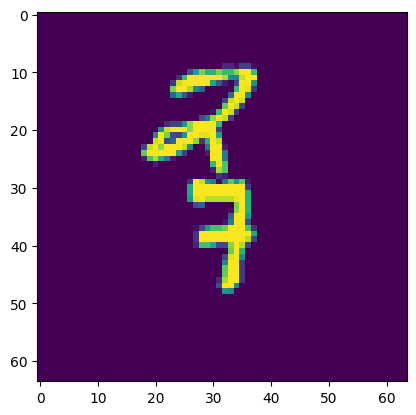

torch.Size([64, 64])


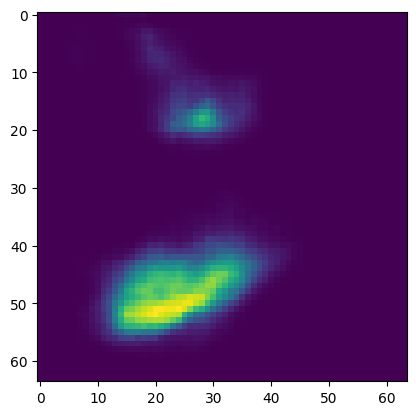

In [280]:
modelMDNRNN.eval()

z, z_next_true = next(iter(train_loader))
z, z_next_true = z.to(device), z_next_true.to(device)

model.eval()

with torch.no_grad():
  pi, mu_pred, sigma_pred, _ = modelMDNRNN(z, tau=tau, h=None)

  z_next_sampled = sample_mdn(pi[1].unsqueeze(0), mu_pred[1].unsqueeze(0), sigma_pred[1].unsqueeze(0))


  plt.imshow(_frames[1].squeeze(0).cpu().numpy(), interpolation='nearest')
  plt.show()

  reconstructed = model.decode(z_next_sampled.squeeze(0))
  reconstructed = reconstructed.squeeze()
  print(reconstructed.shape)
  plt.imshow(reconstructed.cpu().numpy(), interpolation='nearest')
  plt.show()